# Batch running of multiple optimizations in parallel

In the previous tutorials, we used CMA-ES to optimize the model parameters for a single subject, using a single optimization run. However, in practice, we often want to: 

1. Fit the model to empirical data from multiple subjects or groups. 
2. Perform multiple optimization runs per subject using different random seeds, to reduce the chance of converging to local minima.

At the same time, the CMA-ES runs we performed earlier used only a small number of simulations in parallel (24 particles for the [homogeneous model](cmaes_homo.ipynb) and 64 for the [heterogeneous model](cmaes_het.ipynb)). Depending on the GPU hardware, this typically underutilizes the available GPU resources.

To address this, the cuBNM toolbox includes functionality for batch-running multiple optimizations in parallel: across subjects, across runs for the same subject, or both. This helps fully leverage the GPU and improves efficiency compared to running the optimizations independently and serially.

In this tutorial, we'll use this batch optimization functionality to run four CMA-ES optimizations in parallel for two subjects from the MICA-MICs dataset, running two optimizations (with different sampling seeds) per subject. 

## Loading the data

We will use the data of the first two subjects from the MICA-MICs dataset. `sub-HC001` is the same subject used in the previous tutorials, but the data for `sub-HC002` is not included in the toolbox. To load the data of this subject, we’ll first need to download and extract the required files from the MICA-MICs dataset via OSF.

<div class="alert alert-info">
<p>
This will download approximately <b>2.6 GB</b> of data into the current working directory.
</p>
</div>

In [1]:
%%bash

# download the full micapipe output of MICA-MICs (if not present)
if [ ! -f micapipe_MICs_v1.1.zip ]; then
    wget --quiet -O micapipe_MICs_v1.1.zip https://osf.io/download/x7qr2/
fi

# unzip only the data that we need: BOLD signal + SC in Schaefer-100 (if not present)
if [ ! -d micapipe_MICs_v1.1 ]; then
    unzip micapipe_MICs_v1.1.zip \
        'micapipe/sub-*/ses-01/func/*_ses-01_space-fsnative_atlas-schaefer100_desc-timeseries.txt'\
        'micapipe/sub-*/ses-01/dwi/*_ses-01_space-dwinative_atlas-schaefer100_desc-sc.txt'\
        -d micapipe_MICs_v1.1
fi

We now load the structural connectomes (SC) and empirical BOLD signals for the two selected subjects from the MICA-MICs dataset:

In [3]:
from cubnm import datasets, utils

subjects = ['sub-HC001', 'sub-HC002']

scs = {}
emp_bolds = {}

for sub in subjects:
    scs[sub] = datasets.load_sc('strength', 'schaefer-100', sub, micamics_dir='./micapipe_MICs_v1.1/micapipe')
    emp_bolds[sub] = datasets.load_bold('schaefer-100', sub, micamics_dir='./micapipe_MICs_v1.1/micapipe')

Let’s fist visualize the SC matrices and BOLD signals:

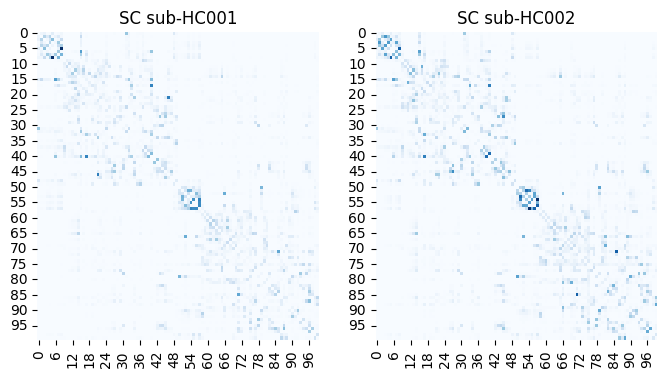

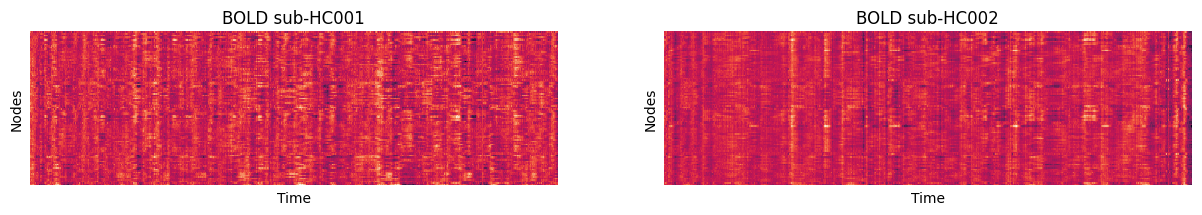

In [3]:
from cubnm import datasets
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for i_sub, sub in enumerate(subjects):
    sns.heatmap(scs[sub], cmap='Blues', cbar=False, ax=axes[i_sub])
    axes[i_sub].set_title(f"SC {sub}")
    
fig, axes = plt.subplots(1, 2, figsize=(15, 2))
for i_sub, sub in enumerate(subjects):
    ax = axes[i_sub]
    sns.heatmap(emp_bolds[sub], cbar=False, ax=ax)
    ax.set_ylabel("Nodes")
    ax.set_xlabel("Time")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"BOLD {sub}")

## Running batch optimization

Now we'll create separate `BNMProblem` objects for each subject. These will define heterogeneous rWW models with FIC, similar to the model used in [the single-run heterogeneous CMA-ES tutorial](cmaes_het.ipynb). Note that each subject has a different `sc`, `emp_bold`, and `out_dir`, so we pass `sc` directly to the `BNMProblem` instead of including it in `sim_options` dictionary.

In [4]:
import os
from cubnm import optimize

# define simulation options
sim_options = dict(
    duration=435,
    bold_remove_s=15,
    TR=0.6,
    dt='0.1',
    bw_dt='1.0',
    ext_out=True,
    states_ts=True,
    states_sampling=0.1,
    noise_out=False,
    sim_seed=421,
    noise_segment_length=30,
    gof_terms=['+fc_corr', '-fcd_ks'],
    do_fc=True,
    do_fcd=True,
    window_size=30,
    window_step=5,
    fcd_drop_edges=True,
    exc_interhemispheric=False,
    bw_params='heinzle2016-3T',
    sim_verbose=True,
    do_fic=True,
    max_fic_trials=0
)
# disable simulation verbosity
sim_options['sim_verbose'] = False

# load biological maps used for map-based heterogeneity
maps = datasets.load_maps(['myelinmap', 'fcgradient01'], parc='schaefer-100', norm='minmax')

# define a map-based heterogeneous problem for each subject
problems = {}
for sub in subjects:
    problems[sub] = optimize.BNMProblem(
        model = 'rWW',
        params = {
            'G': (0.5, 10.0), 
            'wEE': (0.01, 2.1),
            'wEI': (0.01, 1.5)
        },
        emp_bold = emp_bolds[sub], # subject-specific bold signal
        sc = scs[sub], # subject-specific SC
        het_params = ['wEE', 'wEI'],
        maps = maps,
        maps_coef_range = (-5, 5),
        out_dir = os.path.join('./batch_cmaes', sub), # subject-specific output directories
        **sim_options
    )
    
problems

{'sub-HC001': <cubnm.optimize.BNMProblem at 0x146ef91d4880>,
 'sub-HC002': <cubnm.optimize.BNMProblem at 0x146ef8943160>}

Next, we define two CMA-ES optimizers with different seeds. These will be reused across subjects, and subject-specific copies of the optimizers will be created internally. 

In [ ]:
optimizers = {}
for seed in [1, 2]:
    optimizers[seed] = optimize.CMAESOptimizer(
        popsize=64,
        n_iter=81, 
        seed=seed,
        algorithm_kws=dict(tolfun=5e-3),
        print_history=False
    )

Note that:

- Unlike single-run optimizations, we do not need to call `setup_problem()` as it is handled internally during batch optimization.
- `print_history` is set to `False` for cleaner output.

We can now run all four optimization runs (2 subjects × 2 seeds) in parallel using the `optimize.batch_optimize()` function. This function takes lists of problems and optimizers corresponding to each run. After running the optimizations, it returns fitted copies of the provided `Optimizer` (e.g. `CMAESOptimizer`) instances.


<div class="alert alert-info">
<p>
Technical Note: Internally, `batch_optimize()` creates a `MultiSimGroup` by merging the `SimGroup` objects of all provided `BNMProblem`s. This allows the simulations to be run in parallel on GPU. After the optimization is complete, it re-runs the optimal simulations (by default, when `save=True`) and saves all results to disk, just like in individual runs.
</p>
</div>

In [6]:
%%time
# define the corresponding lists of problems and optimizers for all 4 runs
batch_problems   = [problems['sub-HC001'], problems['sub-HC001'], problems['sub-HC002'], problems['sub-HC002']]
batch_optimizers = [optimizers[1]        , optimizers[2]        , optimizers[1]        , optimizers[2]]

# run batch optimization
fitted_optimizers = optimize.batch_optimize(batch_optimizers, batch_problems)

Initializing GPU session...
took 2.493292 s
Running 256 simulations...
took 35.638886 s
Current session is already initialized
Running 256 simulations...
took 35.603441 s
Current session is already initialized
Running 256 simulations...
took 35.584529 s
Current session is already initialized
Running 256 simulations...
took 35.326950 s
Current session is already initialized
Running 256 simulations...
took 35.771922 s
Current session is already initialized
Running 256 simulations...
took 35.718560 s
Current session is already initialized
Running 256 simulations...
took 35.475861 s
Current session is already initialized
Running 256 simulations...
took 35.490903 s
Current session is already initialized
Running 256 simulations...
took 35.299875 s
Current session is already initialized
Running 256 simulations...
took 35.183514 s
Current session is already initialized
Running 256 simulations...
took 35.618104 s
Current session is already initialized
Running 256 simulations...
took 35.678439 s

We can observe that, in each iteration (before any optimizer converges), a total of 64 × 4 = 256 simulations are run in parallel.
On an NVIDIA A100 (40 GB) GPU, this takes approximately 35 seconds per generation. For comparison, in [the single-run CMA-ES tutorial](cmaes_het.ipynb) with 64 particles, running 64 simulations per generation took around 16 seconds on average. So, by running all 4 optimizations as a batch (taking around 35 seconds per generation total), instead of running them individually (which would take 16 × 4 = 64 seconds per generation), we have made the process approximately 2× more efficient.

<div class="alert alert-info">
<p>
Efficiency gains of batch optimization will depend on the GPU hardware, but it typically becomes more efficient as more optimizations are included, up to the hardware’s parallelization limits.
</p>
</div>

## Visualization of the results

Just like the individually-run optimizers from previous tutorials, the batch-fitted optimizers provide:

- `optimizer.history`: The optimization history (free parameters and scores per particle).
- `optimizer.opt`: The set of free parameters with the lowest cost in addition to its associated scores.
- `optimizer.problem.sim_group`: A `SimGroup` (N = 1) object which contains the simulation data (BOLD, FC/D, states (time series), regional parameters) of the optimal simulation.


We will now look at the results of these optimization runs. To make this easier, we first convert the list of returned optimizers into a nested dictionary indexed by subject and seed:

In [6]:
fitted_optimizers_dict = {}
i_run = 0
for sub in subjects:
    fitted_optimizers_dict[sub] = {}
    for seed in [1, 2]:
        fitted_optimizers_dict[sub][seed] = fitted_optimizers[i_run]
        i_run += 1

### Negative cost trajectories

We can visualize how negative cost evolved over the course of the 4 CMA-ES optimization runs. Here, to indicate better simulations with higher values, rather than the cost function we will visualize negative cost function.

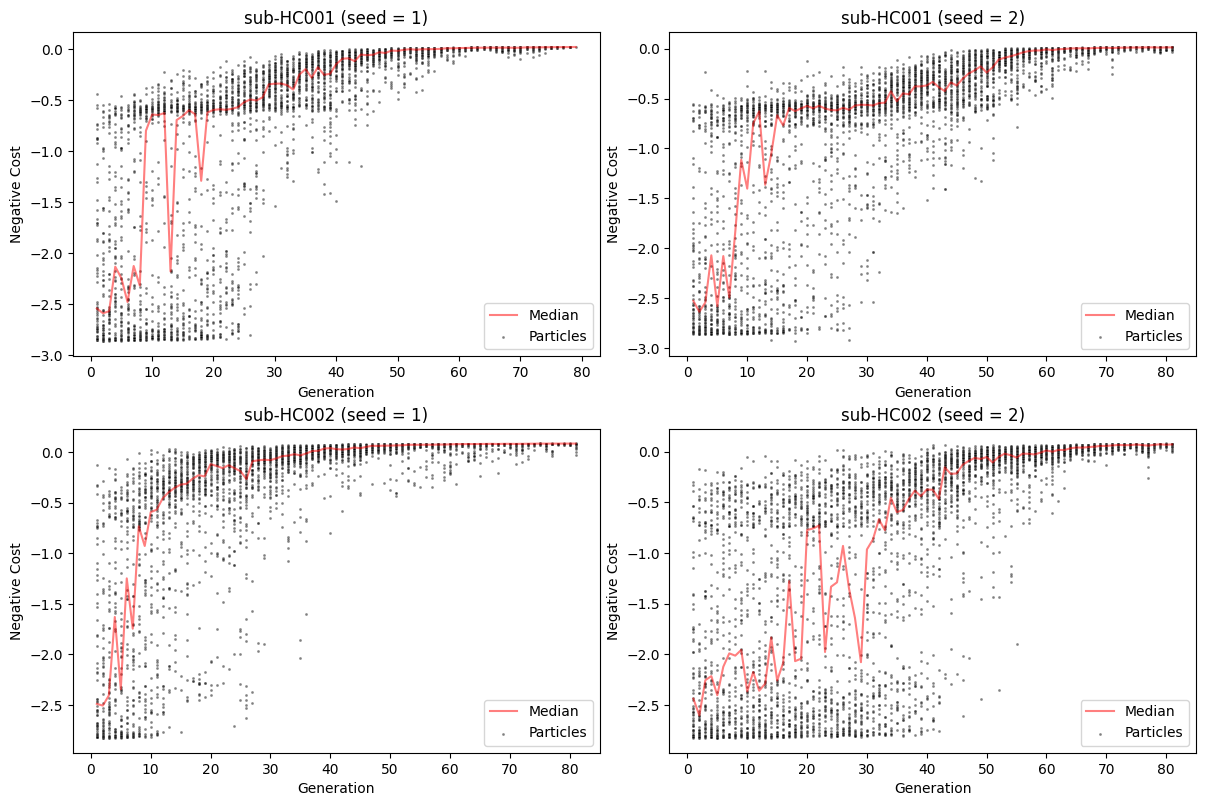

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i_sub, sub in enumerate(subjects):
    for i_seed, seed in enumerate([1, 2]):
        # calculate negative cost
        hist = fitted_optimizers_dict[sub][seed].history.copy()
        hist['-cost'] = -hist['cost']
        # calculate its median in each generation
        hist_median = hist.groupby("gen")["-cost"].median()
        # plot
        ax = axes[i_sub, i_seed]
        # median
        ax.plot(hist_median, color="red", alpha=0.5, label='Median')
        # individual particles
        sns.scatterplot(data=hist, x='gen', y='-cost', s=4, alpha=0.5, color='black', ax=ax, label='Particles')
        # aesthetics
        ax.set_ylabel('Negative Cost')
        ax.set_xlabel('Generation')
        ax.set_title(f'{sub} (seed = {seed})')
        ax.legend()

fig.tight_layout(pad=0.5)

Each subplot shows one optimization run. We can use these plots to evaluate convergence behavior across seeds and subjects.

### Parameters and state variables of optimal simulations

We now visualize the global coupling parameter $G$ and the regional values of $w^{EE}$ and $w^{EI}$ for the optimal simulations from each of the four runs:

[Text(0, 0.5, 'sub-HC001 (seed = 1)'),
 Text(0, 1.5, 'sub-HC001 (seed = 2)'),
 Text(0, 2.5, 'sub-HC002 (seed = 1)'),
 Text(0, 3.5, 'sub-HC002 (seed = 2)')]

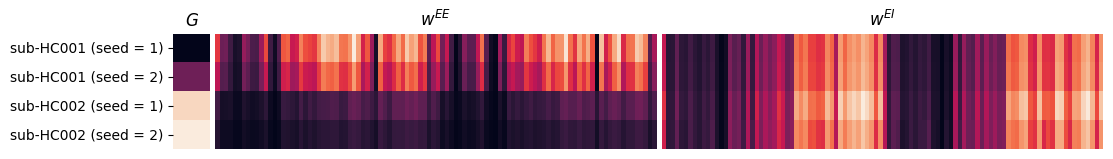

In [8]:
import numpy as np

# create the axes
fig, axd = plt.subplot_mosaic(
    [["G"] + ["space0"] + ["wEE"] * 100 + ["space1"] + ["wEI"] * 100],
    gridspec_kw=dict(width_ratios=[10] + [1] * 202),
    figsize=(12, 1.5)
)
# plot heatmaps of parameters
sns.heatmap(np.array([o.problem.sim_group.param_lists['G'][0] for o in fitted_optimizers])[:, None], cbar=False, ax=axd['G'])
axd['G'].set_title(r'$G$')
sns.heatmap(np.array([o.problem.sim_group.param_lists['wEE'][0] for o in fitted_optimizers]), cbar=False, ax=axd['wEE'])
axd['wEE'].set_title(r'$w^{EE}$')
sns.heatmap(np.array([o.problem.sim_group.param_lists['wEI'][0] for o in fitted_optimizers]), cbar=False, ax=axd['wEI'])
axd['wEI'].set_title(r'$w^{EI}$')
# aesthetics and labeling
for ax in list(axd.values())[1:]:
    ax.axis('off')
axd['G'].set_xticks([])
labels = []
for sub in subjects:
    for seed in [1, 2]:
        labels.append(f'{sub} (seed = {seed})')
axd['G'].set_yticklabels(labels, rotation=0)

We observe that the spatial patterns of the regional parameters are quite consistent across runs for the same subject (and to some extent even across different subjects) highlighting the stability of the optimization.

Similarly, we can also visualize node-wise time-averaged values of a model state, such as the input to excitatory neuronal ensembles $I^E$, for each optimal simulation. Here, we compute the average after discarding the initial 30 seconds of simulated time (based on `sim_group.n_states_samples_remove` calculated based on `bold_remove_s` = 30 seconds and `states_sampling` = 0.1 seconds, both defined in `sim_options` dictionary).

Text(0.5, 1.0, '$\\langle I^E \\rangle$')

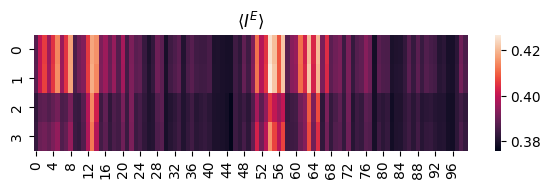

In [19]:
# calculate time-average node-wise I_E in optimal simulations
# after discarding the initial 30 seconds
I_E_avgs = np.array([
    o.problem.sim_group.sim_states['I_E'][0, o.problem.sim_group.n_states_samples_remove:, :].mean(axis=0)
    for o in fitted_optimizers
])
# plot
fig, ax = plt.subplots(figsize=(7, 1.5))
sns.heatmap(I_E_avgs, ax=ax)
ax.set_title(r'$\langle I^E \rangle$')

Again, we observe that the spatial patterns of $\langle I^E \rangle$ are comparable across runs.

### Goodness-of-fit in the best runs across subjects

For each subject, we select the best optimization run, i.e., the run with the lowest cost across the two CMA-ES runs:

In [21]:
best_optimizers = {}

for sub in subjects:
    best_cost = np.inf
    for seed in [1, 2]:
        if fitted_optimizers_dict[sub][seed].opt['cost'] < best_cost:
            best_cost = fitted_optimizers_dict[sub][seed].opt['cost']
            best_seed = seed
            best_optimizers[sub] = fitted_optimizers_dict[sub][seed]
    print(f'{sub} best run has seed = {best_seed}')
    print(fitted_optimizers_dict[sub][best_seed].opt)

sub-HC001 best run has seed = 1
index           18.000000
G                2.356322
wEE              0.078068
wEI              0.238414
wEEscale0       -3.162811
wEEscale1       -0.177060
wEIscale0       -1.003503
wEIscale1        4.992518
cost            -0.019117
+fc_corr         0.314580
-fcd_ks         -0.168808
+gof             0.145772
-fic_penalty    -0.126655
gen             75.000000
Name: 4754, dtype: float64
sub-HC002 best run has seed = 1
index           44.000000
G                2.805618
wEE              0.010155
wEI              0.278468
wEEscale0       -4.162219
wEEscale1        3.060576
wEIscale0       -1.003233
wEIscale1        4.995811
cost            -0.086524
+fc_corr         0.332866
-fcd_ks         -0.184844
+gof             0.148022
-fic_penalty    -0.061498
gen             75.000000
Name: 4780, dtype: float64


The best run happened to be the one with seed = 1 for both subjects.

<div class="alert alert-info">
<p>
The optimal simulation for the first subject is identical to the one obtained in the [single-run heterogeneous CMA-ES tutorial](cmaes_het.ipynb), since both used the same model and optimizer configurations. This serves as a sanity check, confirming that the optimizer produces consistent results whether run individually or as part of a batch.    
</p>
</div>

For the best run of each subject, we can then visualize:

- The regression plot comparing simulated and empirical functional connectivity (FC)
- The distribution comparison between simulated and empirical functional connectivity dynamics (FCD)

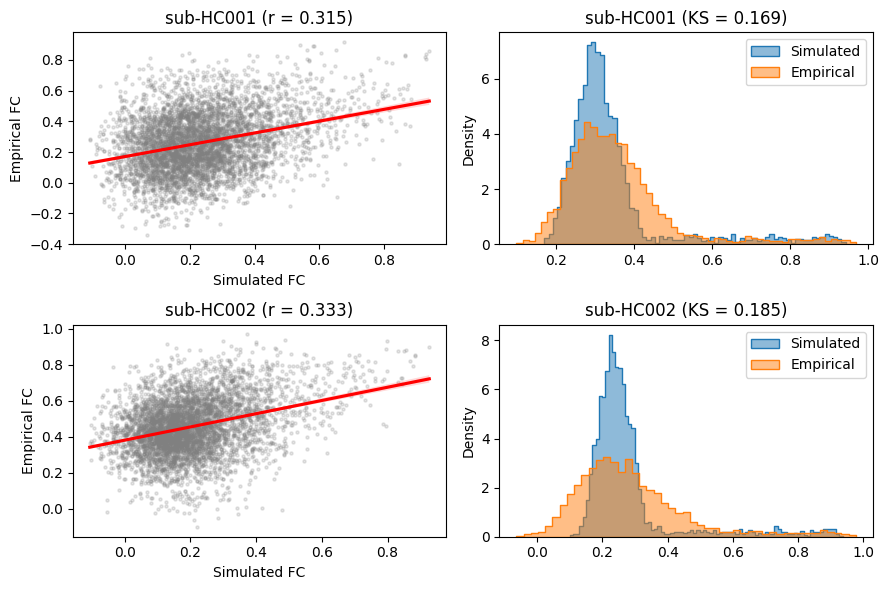

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(9, 6))
axes = axes.flatten()
for i_sub, sub in enumerate(subjects):
    # regression plot
    ax = axes[i_sub*2] 
    sns.regplot(
        x=best_optimizers[sub].problem.sim_group.sim_fc_trils[0],
        y=best_optimizers[sub].problem.emp_fc_tril,
        scatter_kws=dict(s=5, alpha=0.2, color="grey"),
        line_kws=dict(color="red"),
        ax=ax
    )
    ax.set_xlabel("Simulated FC")
    ax.set_ylabel("Empirical FC")
    # add fc_corr statistic
    ax.set_title(f'{sub} (r = {best_optimizers[sub].opt["+fc_corr"]:.3f})')
    # histograms
    ax = axes[i_sub*2+1]
    sns.histplot(best_optimizers[sub].problem.sim_group.sim_fcd_trils[0], element='step', alpha=0.5, label='Simulated', stat='density', ax=ax)
    sns.histplot(best_optimizers[sub].problem.emp_fcd_tril, element='step', alpha=0.5, label='Empirical', stat='density', ax=ax)
    ax.legend()
    # add fcd_ks statistic
    # -fcd_ks in .opt needs to be negated to have positive values
    ax.set_title(f'{sub} (KS = {-best_optimizers[sub].opt["-fcd_ks"]:.3f})')
fig.tight_layout()

## Limitations of batch optimization

Currently, batch optimization supports varying only the following attributes across the batched BNMProblem instances:

- `sc`: Structural connectivity strength matrix
- `emp_bold`: Empirical BOLD signal
- `out_dir`: Output directory

<div class="alert alert-info">
<p>
Note: When multiple optimizers are run on the same problem, their outputs are saved in the same directory and automatically numbered, e.g., `out_dir/cmaes_run-0`, `out_dir/cmaes_run-1`, etc.
</p>
</div> 

All other model and simulation parameters must be identical across batched problems. This includes, for example:

- `sc_dist`: Structural connectivity lengths (used in simulations with conduction delays)
- `sim_seed`: Random seed for generating simulation noise

In addition, all optimizers that are batched together must be:

- Subclasses of `PymooOptimizer` (e.g., `CMAESOptimizer`). Therefore, `GridOptimizer` for example is not supported.
- Of the same optimizer type across all runs, therefore it is not possible to mix e.g., CMA-ES with NSGA-II.

However, optimizer-specific properties, including `seed`, `popsize` and `n_iter` can differ between runs.

<div class="alert alert-info">
<p>
The toolbox may support varying additional features across batched problems and optimizers in the future versions.
</p>
</div>